In [4]:
import numpy as np
#from autograd import grad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick

from scipy.optimize import minimize
#import tensorflow as tf
#import torch
np.set_printoptions(suppress=True)

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

# Import data
X = np.load('../data/processed/data_tensor_JJ.npz')

N = X['N']
M = X['M']
y = X['y']
z = X['z']
n_y = X['n_y']
n_z = X['n_z']
area = X['area']
wind = X['wind']
distance = X['distance']
sI1 = X['sI1']
sI2 = X['sI2'] 
tI1 = X['tI1']
tI2 = X['tI2']
s_i = X['s_i']
s_j = X['s_j']

# Load parameters
checkpoint = np.load('../reports/checkpoint_June_July.npy', allow_pickle=True)
theta = checkpoint[0]

In [2]:
m = 1

N_i = int(N[m])

# Number of yards i in prior month
N_lag = int(N[m-1])

# Number of yards j in prior month
M_lag = int(M[m-1])

# Number of diseased plants in yard i in prior month
y_lag = y[m-1, 0:N_lag]
y_lag = y_lag.reshape(N_lag, 1)

# Number of plants sampled in yard i in prior month
n_y_lag = n_y[m-1, 0:N_lag]
n_y_lag = n_y_lag.reshape(N_lag, 1)

# Number of diseased plants in yard i in current month
y_i = y[m, 0:N[m]]
y_i = np.median(y_i.reshape(N[m], 1))

# Number of plants sampled in yard i in current month
n_y_i = n_y[m, 0:N[m]]
n_y_i = np.median(n_y_i.reshape(N[m], 1))

# Number of diseased plants in yard j in prior month
z_lag = y[m-1, 0:M_lag]
z_lag = z_lag.reshape(M_lag, 1)

# Number of plants sampled in yard j in prior month
n_z_lag = n_y[m-1, 0:M_lag]
n_z_lag = n_z_lag.reshape(M_lag, 1)

# Total monthly sprays for yard i in prior month
s_i_lag = s_i[m-1, 0:N_lag]
s_i_lag = np.median(s_i_lag.reshape(N_lag, 1))

# Total monthly sprays for yard j in prior month
s_j_lag = s_j[m-1, 0:M_lag]
s_j_lag = np.median(s_j_lag.reshape(M_lag, 1))

# Area in hectares of yard j [in prior month]
area_lag = area[m-1, 0:M_lag]
area_lag = np.median(area_lag.reshape(M_lag, 1))

# Wind run of yard j in prior month
wind_lag = np.median(wind[m-1, 0:N_lag, 0:M_lag])

# Distance in km between yard i and j [in prior month]
distance_lag = np.median(distance[m-1, 0:N_lag, 0:M_lag])



## R6 - R6 configuration for monthly sprays

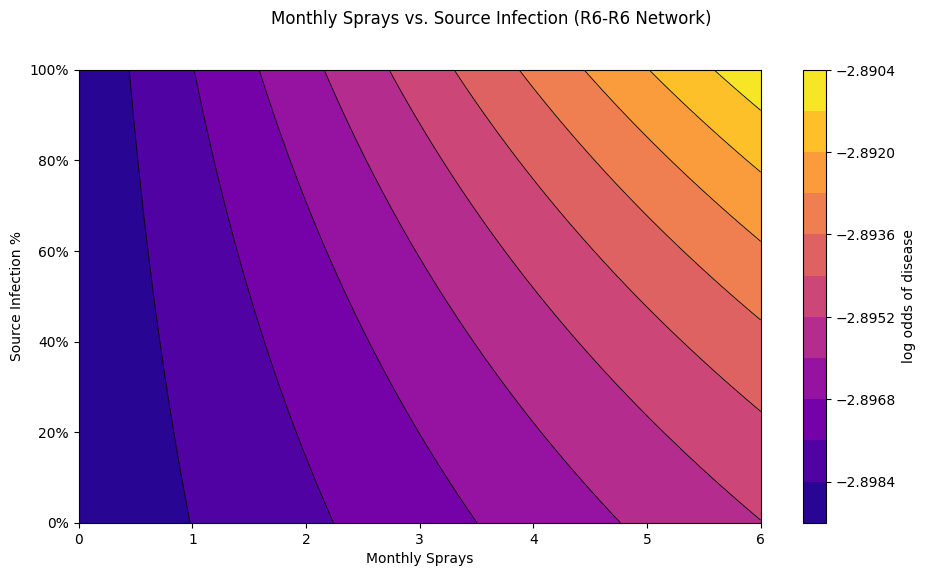

In [40]:
figure(figsize=(11, 6), dpi=100)


# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 1

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 1

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 0


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, source_infection, s_j_lag):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.median(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.median(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, source_infection, s_j_lag):
    
    p = 1 / (1 + np.exp(-eta(theta, source_infection, s_j_lag)))
    
    return p



# Contour plot of log-odds of disease

X = np.linspace(0, 6, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)


Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')

plt.xlabel('Monthly Sprays')
plt.ylabel('Source Infection %')
plt.suptitle('Monthly Sprays vs. Source Infection (R6-R6 Network)')


cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

### Effect of monthly sprays and source infection %

**Network 1**

```{r}

Source yard is affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

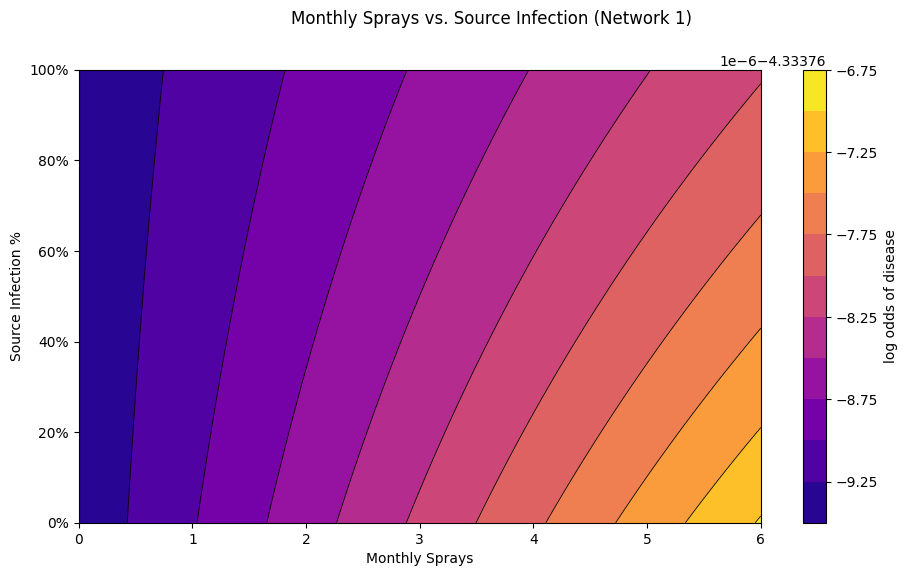

In [39]:
figure(figsize=(11, 6), dpi=100)


# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 1

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, source_infection, s_j_lag):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.median(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.median(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, source_infection, s_j_lag):
    
    p = 1 / (1 + np.exp(-eta(theta, source_infection, s_j_lag)))
    
    return p



# Contour plot of log-odds of disease

X = np.linspace(0, 6, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)


Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')

plt.xlabel('Monthly Sprays')
plt.ylabel('Source Infection %')
plt.suptitle('Monthly Sprays vs. Source Infection (Network 1)')


cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

### Effect of monthly sprays and source infection %
**Network 2**

```{r}


Source yard is not affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

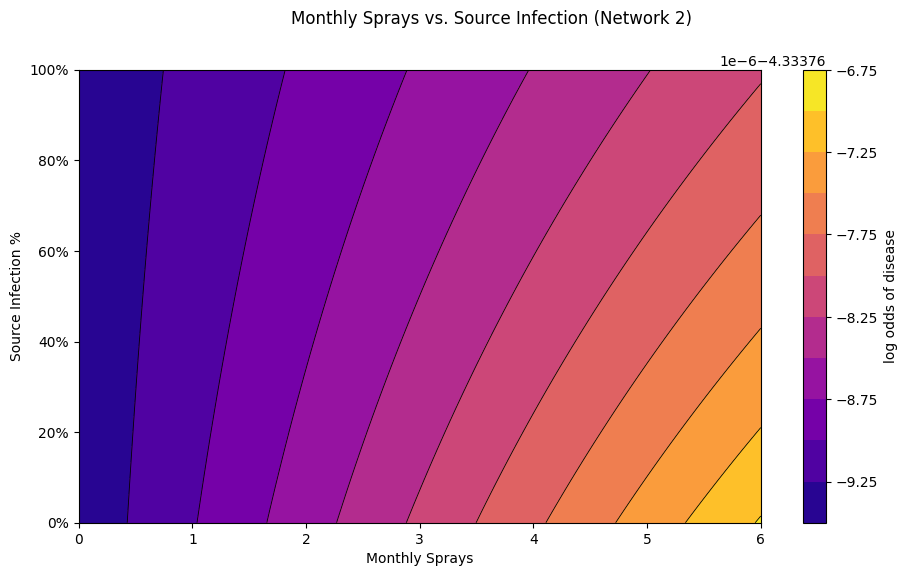

In [7]:
figure(figsize=(11, 6), dpi=100)

# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 0

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, source_infection, s_j_lag):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.median(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.median(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, source_infection, s_j_lag):
    
    p = 1 / (1 + np.exp(-eta(theta, source_infection, s_j_lag)))
    
    return p



# Contour plot of log-odds of disease

X = np.linspace(0, 6, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)


Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')

plt.xlabel('Monthly Sprays')
plt.ylabel('Source Infection %')
plt.suptitle('Monthly Sprays vs. Source Infection (Network 2)')


cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

**Network 1**

```{r}

Source yard is affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

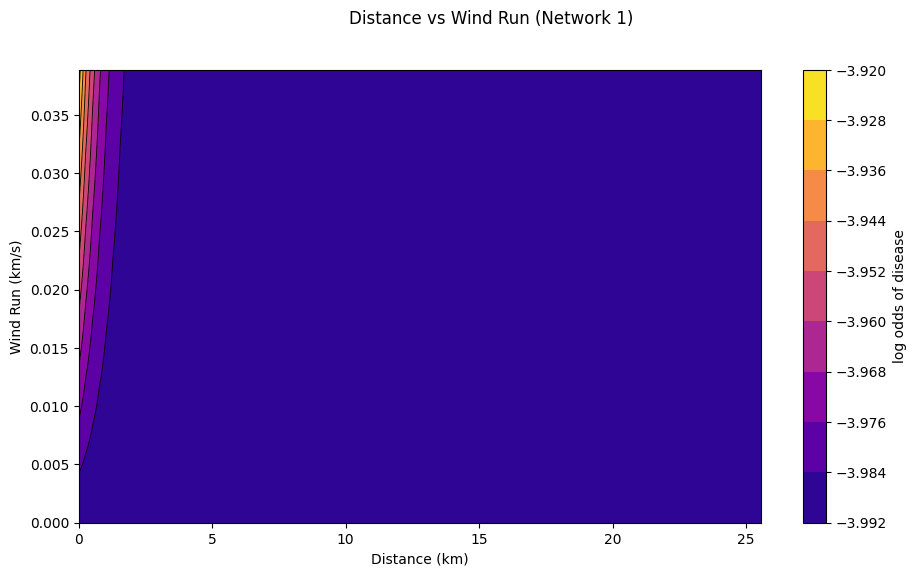

In [9]:
# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 1

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, distance_X, wind_Y):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * np.mean(z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_Y * np.exp(-alpha1 * distance_X)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * np.mean(z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_Y * np.exp(-alpha2 * distance_X)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, distance_X, wind_Y):
    
    p = 1 / (1 + np.exp(-eta(theta, distance_X, wind_Y)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(np.min(distance), np.max(distance), 100)
Y = np.linspace(np.nanmin(wind), np.nanmax(wind), 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Distance (km)')
plt.ylabel('Wind Run (km/s)')
plt.suptitle('Distance vs Wind Run (Network 1)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.show()

**Network 2**

```{r}

Source yard is not affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

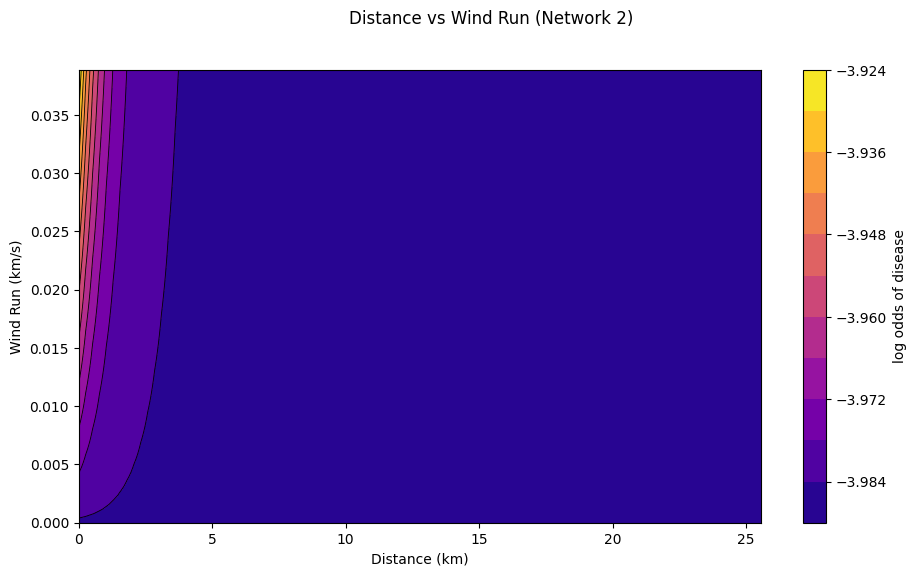

In [188]:
# Load parameters
checkpoint = np.load('../reports/checkpoint_June_July.npy', allow_pickle=True)
theta = checkpoint[0]

# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 0

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, distance_X, wind_Y):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * np.mean(z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_Y * np.exp(-alpha1 * distance_X)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * np.mean(z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_Y * np.exp(-alpha2 * distance_X)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, distance_X, wind_Y):
    
    p = 1 / (1 + np.exp(-eta(theta, distance_X, wind_Y)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(np.min(distance), np.max(distance), 100)
Y = np.linspace(np.nanmin(wind), np.nanmax(wind), 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Distance (km)')
plt.ylabel('Wind Run (km/s)')
plt.suptitle('Distance vs Wind Run (Network 2)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.show()

### Effect of Distance and Source Infection %

**Network 1**

```{r}

Source yard is affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

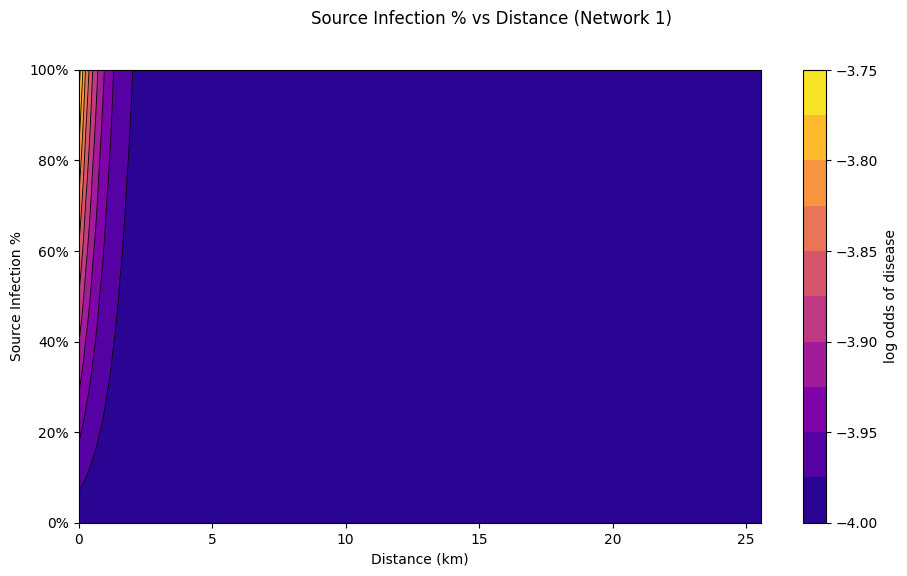

In [10]:
# Load parameters
checkpoint = np.load('../reports/checkpoint_June_July.npy', allow_pickle=True)
theta = checkpoint[0]

# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 1

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, distance_X, source_infection):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_X)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_X)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, distance_X, source_infection):
    
    p = 1 / (1 + np.exp(-eta(theta, distance_X, source_infection)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(np.min(distance), np.max(distance), 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Distance (km)')
plt.ylabel('Source Infection %')
plt.suptitle('Source Infection % vs Distance (Network 1)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

**Network 2**

```{r}

Source yard is not affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

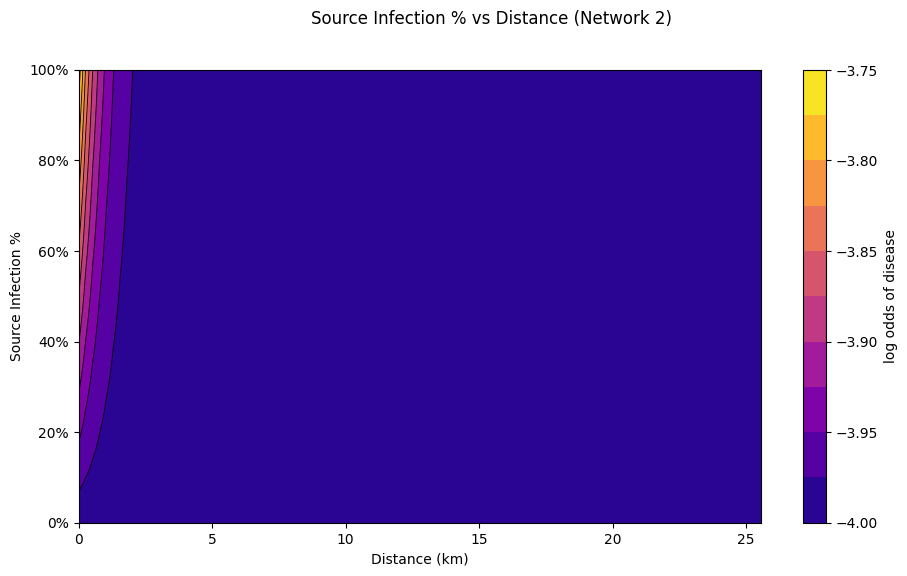

In [11]:
# Load parameters
checkpoint = np.load('../reports/checkpoint_June_July.npy', allow_pickle=True)
theta = checkpoint[0]

# Network configuration

# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 0

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, distance_X, source_infection):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_X)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_X)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, distance_X, source_infection):
    
    p = 1 / (1 + np.exp(-eta(theta, distance_X, source_infection)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(np.min(distance), np.max(distance), 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Distance (km)')
plt.ylabel('Source Infection %')
plt.suptitle('Source Infection % vs Distance (Network 2)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

### Effect of Source Infection % and Wind Run

**Network 1**

```{r}

Source yard is affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

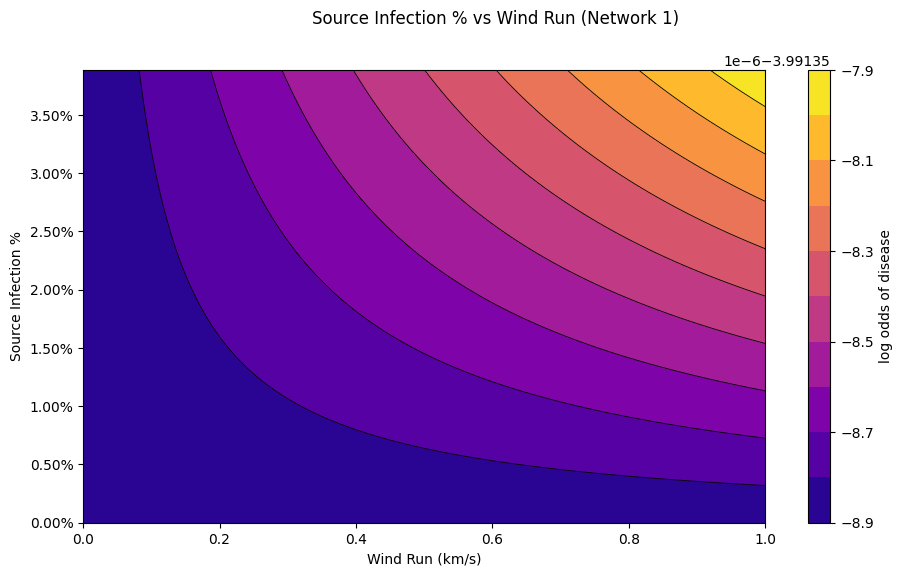

In [12]:
# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 1

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, source_infection, wind_Y):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_Y * np.exp(-alpha1 * distance_lag)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_Y * np.exp(-alpha2 * distance_lag)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, source_infection, wind_Y):
    
    p = 1 / (1 + np.exp(-eta(theta, source_infection, wind_Y)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(0, 1, 100)
Y = np.linspace(np.nanmin(wind), np.nanmax(wind), 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Wind Run (km/s)')
plt.ylabel('Source Infection %')
plt.suptitle('Source Infection % vs Wind Run (Network 1)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

**Network 2**

```{r}

Source yard is not affected by an R6-virulent race in prior month


Target yard is susceptible to both races in current month

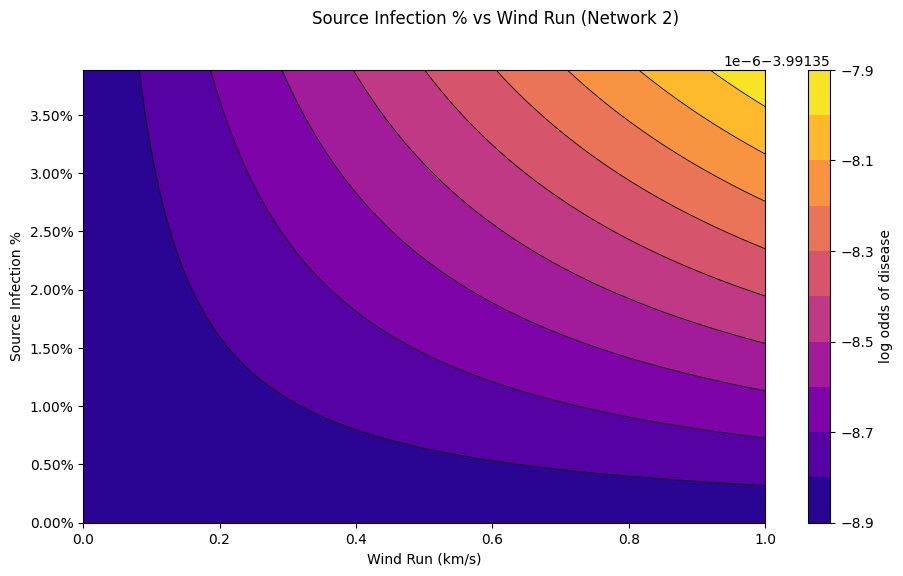

In [13]:
# Indicator on whether yard j is affected by an R6-virulent race in prior month
#sI1_lag = sI1[m-1, 0:M_lag]
sI1_lag = 0

# Constant array of 1's for yard j [in prior month]
#sI2_lag = sI2[m-1, 0:M_lag]
sI2_lag = 1

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
#tI1_i = tI1[m, 0:N[m]]
tI1_i = 0

# Indicator on whether yard i is susceptible to both races in current month
#tI2_i = tI2[m, 0:N[m]]
tI2_i = 1


# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, source_infection, wind_Y):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * np.mean(y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * np.mean(y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * ((area_lag * source_infection) * np.exp(-eta21 * s_j_lag) * (wind_Y * np.exp(-alpha1 * distance_lag)) * sI1_lag)
    dispersal_component2 = gamma2 * ((area_lag * source_infection) * np.exp(-eta22 * s_j_lag) * (wind_Y * np.exp(-alpha2 * distance_lag)) * sI2_lag)
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


# Define the probability of disease
def prob(theta, source_infection, wind_Y):
    
    p = 1 / (1 + np.exp(-eta(theta, source_infection, wind_Y)))
    
    return p



# Contour plot of log-odds of disease

figure(figsize=(11, 6), dpi=100)

X = np.linspace(0, 1, 100)
Y = np.linspace(np.nanmin(wind), np.nanmax(wind), 100)
X, Y = np.meshgrid(X, Y)

Z = eta(theta, X, Y)

plt.contourf(X, Y, Z, 10, cmap='plasma')


plt.xlabel('Wind Run (km/s)')
plt.ylabel('Source Infection %')
plt.suptitle('Source Infection % vs Wind Run (Network 2)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('log odds of disease')
plt.contour(X, Y, Z, 10, colors='black', linestyles='solid', linewidths=0.6)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()